In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, 
                 imaging_type_encoder=None, fit_imaging_type_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_imaging_type_encoder (bool): Whether to fit the imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type labels
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_imaging_type_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_imaging_type_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding and imaging type encoding
    """
    # Create training dataset and fit both label encoders
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True,
        fit_imaging_type_encoder=True
    )
    
    # Get the fitted label encoders
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same encoders
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same encoders
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder    

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:  # Unpack in order: images, labels, imaging_types
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
class XCiTWithImagingType(nn.Module):
    def __init__(self, xcit_model, num_classes=4):
        """
        Wrapper to add imaging type as an additional input to XCiT model
        
        Args:
            xcit_model: Pre-trained XCiT model from timm
            num_classes: Number of output classes
        """
        super(XCiTWithImagingType, self).__init__()
        self.xcit = xcit_model
        
        # Get the feature dimension from the classifier
        if hasattr(self.xcit, 'head'):
            feature_dim = self.xcit.head.in_features
            self.xcit.head = nn.Identity()  # Remove the original classifier
        else:
            feature_dim = 768  # Default for XCiT models
        
        # New classifier that takes imaging type as well
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim + 1, 256),  # +1 for imaging type
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x, imaging_type):
        # Get features from XCiT
        features = self.xcit(x)
        
        # Convert imaging_type to float and reshape to (batch_size, 1)
        imaging_type = imaging_type.float().view(-1, 1)
        
        # Concatenate features with imaging type
        combined = torch.cat([features, imaging_type], dim=1)
        
        # Pass through classifier
        output = self.classifier(combined)
        
        return output

def create_xcit_model(model_size='medium', num_classes=4, pretrained=True):
    """
    Create XCiT (Cross-Covariance Image Transformer) model with imaging type input
    
    Args:
        model_size (str): Size of the model ('tiny', 'small', or 'medium')
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
    
    Returns:
        model: XCiT model with imaging type input
    """
    model_configs = {
        'tiny': 'xcit_tiny_12_p16_224',
        'small': 'xcit_small_12_p16_224',
        'medium': 'xcit_medium_24_p16_224'
    }
    
    if model_size not in model_configs:
        raise ValueError(f"model_size must be one of {list(model_configs.keys())}")
    
    # Create base XCiT model
    base_model = timm.create_model(model_configs[model_size], pretrained=pretrained, num_classes=num_classes)
    
    # Wrap with imaging type input
    model = XCiTWithImagingType(base_model, num_classes=num_classes)
    
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train XCiT Tiny P16 with Imaging Type

Training XCiT Tiny P16 with Imaging Type


model.safetensors:   0%|          | 0.00/26.9M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:13<00:00,  2.85it/s, Loss=1.4081, Acc=0.3035]


Train Loss: 1.4081 Acc: 0.3035 Macro-F1: 0.2817


Val : 100%|██████████| 10/10 [00:01<00:00,  5.72it/s, Loss=1.3005, Acc=0.2697]


Val Loss: 1.3005 Acc: 0.2697 Macro-F1: 0.2074
✓ New best model saved with validation macro-F1: 0.2074

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=1.2141, Acc=0.4309]


Train Loss: 1.2141 Acc: 0.4309 Macro-F1: 0.4008


Val : 100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Loss=1.8542, Acc=0.3454]


Val Loss: 1.8542 Acc: 0.3454 Macro-F1: 0.2135
✓ New best model saved with validation macro-F1: 0.2135

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=1.1821, Acc=0.4729]


Train Loss: 1.1821 Acc: 0.4729 Macro-F1: 0.4217


Val : 100%|██████████| 10/10 [00:01<00:00,  9.58it/s, Loss=1.0782, Acc=0.5000]


Val Loss: 1.0782 Acc: 0.5000 Macro-F1: 0.3722
✓ New best model saved with validation macro-F1: 0.3722

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=1.0251, Acc=0.5863]


Train Loss: 1.0251 Acc: 0.5863 Macro-F1: 0.5079


Val : 100%|██████████| 10/10 [00:01<00:00,  9.53it/s, Loss=1.1106, Acc=0.5164]


Val Loss: 1.1106 Acc: 0.5164 Macro-F1: 0.4598
✓ New best model saved with validation macro-F1: 0.4598

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=1.0417, Acc=0.5304]


Train Loss: 1.0417 Acc: 0.5304 Macro-F1: 0.4944


Val : 100%|██████████| 10/10 [00:01<00:00,  9.33it/s, Loss=1.1936, Acc=0.3849]


Val Loss: 1.1936 Acc: 0.3849 Macro-F1: 0.3113

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.9774, Acc=0.6077]


Train Loss: 0.9774 Acc: 0.6077 Macro-F1: 0.5423


Val : 100%|██████████| 10/10 [00:01<00:00,  8.83it/s, Loss=0.9703, Acc=0.5954]


Val Loss: 0.9703 Acc: 0.5954 Macro-F1: 0.5600
✓ New best model saved with validation macro-F1: 0.5600

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.8747, Acc=0.6291]


Train Loss: 0.8747 Acc: 0.6291 Macro-F1: 0.5843


Val : 100%|██████████| 10/10 [00:01<00:00,  9.44it/s, Loss=0.9480, Acc=0.6316]


Val Loss: 0.9480 Acc: 0.6316 Macro-F1: 0.5254

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.7248, Acc=0.7418]


Train Loss: 0.7248 Acc: 0.7418 Macro-F1: 0.6916


Val : 100%|██████████| 10/10 [00:01<00:00,  9.20it/s, Loss=0.6924, Acc=0.7237]


Val Loss: 0.6924 Acc: 0.7237 Macro-F1: 0.6623
✓ New best model saved with validation macro-F1: 0.6623

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.6141, Acc=0.7812]


Train Loss: 0.6141 Acc: 0.7812 Macro-F1: 0.7403


Val : 100%|██████████| 10/10 [00:01<00:00,  9.56it/s, Loss=1.1476, Acc=0.5362]


Val Loss: 1.1476 Acc: 0.5362 Macro-F1: 0.4338

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.5822, Acc=0.7829]


Train Loss: 0.5822 Acc: 0.7829 Macro-F1: 0.7358


Val : 100%|██████████| 10/10 [00:01<00:00,  8.68it/s, Loss=0.6214, Acc=0.7303]


Val Loss: 0.6214 Acc: 0.7303 Macro-F1: 0.6879
✓ New best model saved with validation macro-F1: 0.6879

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.36it/s, Loss=0.5364, Acc=0.8035]


Train Loss: 0.5364 Acc: 0.8035 Macro-F1: 0.7578


Val : 100%|██████████| 10/10 [00:01<00:00,  9.03it/s, Loss=0.8867, Acc=0.5822]


Val Loss: 0.8867 Acc: 0.5822 Macro-F1: 0.4992

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.4456, Acc=0.8363]


Train Loss: 0.4456 Acc: 0.8363 Macro-F1: 0.8018


Val : 100%|██████████| 10/10 [00:01<00:00,  9.62it/s, Loss=0.5224, Acc=0.8158]


Val Loss: 0.5224 Acc: 0.8158 Macro-F1: 0.7629
✓ New best model saved with validation macro-F1: 0.7629

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.3728, Acc=0.8676]


Train Loss: 0.3728 Acc: 0.8676 Macro-F1: 0.8305


Val : 100%|██████████| 10/10 [00:01<00:00,  9.62it/s, Loss=0.5375, Acc=0.8224]


Val Loss: 0.5375 Acc: 0.8224 Macro-F1: 0.7824
✓ New best model saved with validation macro-F1: 0.7824

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.3763, Acc=0.8692]


Train Loss: 0.3763 Acc: 0.8692 Macro-F1: 0.8351


Val : 100%|██████████| 10/10 [00:01<00:00,  9.24it/s, Loss=0.3653, Acc=0.8882]


Val Loss: 0.3653 Acc: 0.8882 Macro-F1: 0.8554
✓ New best model saved with validation macro-F1: 0.8554

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.2624, Acc=0.9062]


Train Loss: 0.2624 Acc: 0.9062 Macro-F1: 0.8734


Val : 100%|██████████| 10/10 [00:01<00:00,  9.44it/s, Loss=0.2910, Acc=0.9178]


Val Loss: 0.2910 Acc: 0.9178 Macro-F1: 0.8922
✓ New best model saved with validation macro-F1: 0.8922

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.2173, Acc=0.9400]


Train Loss: 0.2173 Acc: 0.9400 Macro-F1: 0.9136


Val : 100%|██████████| 10/10 [00:01<00:00,  9.25it/s, Loss=0.2807, Acc=0.9178]


Val Loss: 0.2807 Acc: 0.9178 Macro-F1: 0.8847

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.38it/s, Loss=0.2208, Acc=0.9375]


Train Loss: 0.2208 Acc: 0.9375 Macro-F1: 0.9101


Val : 100%|██████████| 10/10 [00:01<00:00,  9.68it/s, Loss=0.2735, Acc=0.9243]


Val Loss: 0.2735 Acc: 0.9243 Macro-F1: 0.8992
✓ New best model saved with validation macro-F1: 0.8992

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:12<00:00,  3.13it/s, Loss=0.2096, Acc=0.9416]


Train Loss: 0.2096 Acc: 0.9416 Macro-F1: 0.9121


Val : 100%|██████████| 10/10 [00:01<00:00,  9.38it/s, Loss=0.2808, Acc=0.9211]


Val Loss: 0.2808 Acc: 0.9211 Macro-F1: 0.8922

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.2003, Acc=0.9433]


Train Loss: 0.2003 Acc: 0.9433 Macro-F1: 0.9166


Val : 100%|██████████| 10/10 [00:01<00:00,  9.82it/s, Loss=0.2629, Acc=0.9342]


Val Loss: 0.2629 Acc: 0.9342 Macro-F1: 0.9021
✓ New best model saved with validation macro-F1: 0.9021

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1893, Acc=0.9391]


Train Loss: 0.1893 Acc: 0.9391 Macro-F1: 0.9140


Val : 100%|██████████| 10/10 [00:01<00:00,  9.62it/s, Loss=0.2698, Acc=0.9211]


Val Loss: 0.2698 Acc: 0.9211 Macro-F1: 0.8874

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1815, Acc=0.9408]


Train Loss: 0.1815 Acc: 0.9408 Macro-F1: 0.9146


Val : 100%|██████████| 10/10 [00:01<00:00,  9.60it/s, Loss=0.3049, Acc=0.9079]


Val Loss: 0.3049 Acc: 0.9079 Macro-F1: 0.8744

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1675, Acc=0.9548]


Train Loss: 0.1675 Acc: 0.9548 Macro-F1: 0.9319


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.2620, Acc=0.9276]


Val Loss: 0.2620 Acc: 0.9276 Macro-F1: 0.8975

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1936, Acc=0.9474]


Train Loss: 0.1936 Acc: 0.9474 Macro-F1: 0.9194


Val : 100%|██████████| 10/10 [00:01<00:00,  9.31it/s, Loss=0.2517, Acc=0.9375]


Val Loss: 0.2517 Acc: 0.9375 Macro-F1: 0.9126
✓ New best model saved with validation macro-F1: 0.9126

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1555, Acc=0.9564]


Train Loss: 0.1555 Acc: 0.9564 Macro-F1: 0.9367


Val : 100%|██████████| 10/10 [00:01<00:00,  9.67it/s, Loss=0.2615, Acc=0.9309]


Val Loss: 0.2615 Acc: 0.9309 Macro-F1: 0.9049

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:11<00:00,  3.37it/s, Loss=0.1612, Acc=0.9482]


Train Loss: 0.1612 Acc: 0.9482 Macro-F1: 0.9261


Val : 100%|██████████| 10/10 [00:01<00:00,  9.58it/s, Loss=0.2681, Acc=0.9309]


Val Loss: 0.2681 Acc: 0.9309 Macro-F1: 0.8997

Training complete in 5m 14s
Best validation macro-F1: 0.9126


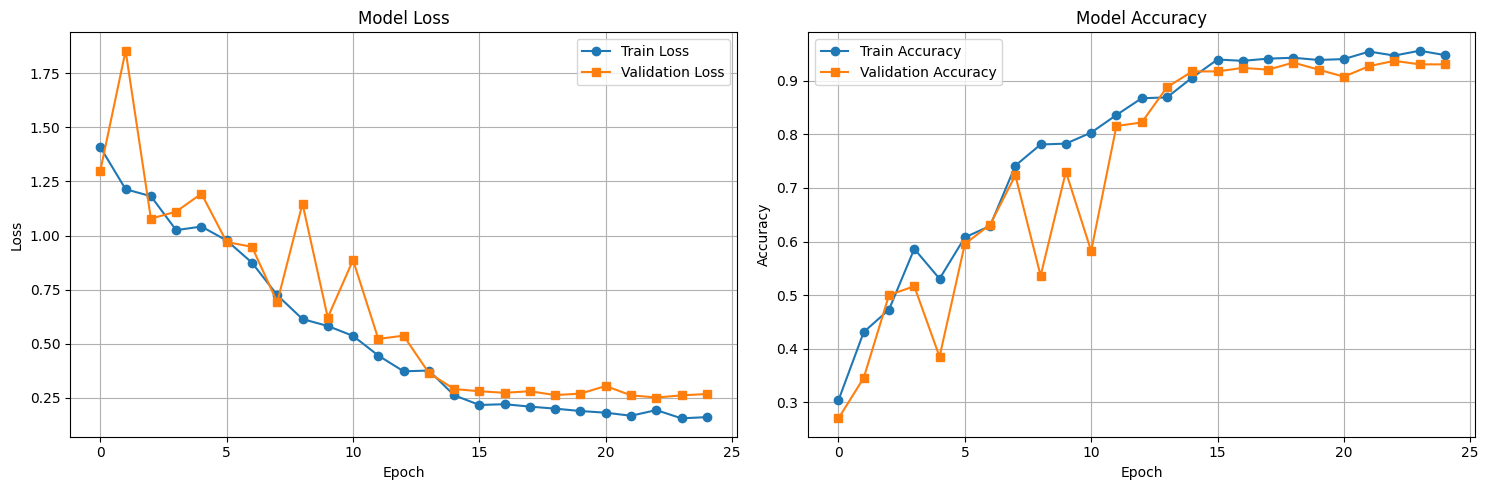

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.68it/s]


Test Accuracy: 45.50%
Test Loss: 2.2685

Classification Report:
              precision    recall  f1-score   support

         HGC       0.78      0.54      0.64        74
         LGC       0.43      0.17      0.24        53
         NST       0.28      0.35      0.31        37
         NTL       0.34      0.96      0.50        25

    accuracy                           0.46       189
   macro avg       0.46      0.51      0.42       189
weighted avg       0.53      0.46      0.45       189


Confusion Matrix:
[[40 12 21  1]
 [11  9 11 22]
 [ 0  0 13 24]
 [ 0  0  1 24]]

ROC-AUC Scores:
Macro-average AUC: 0.7864
Micro-average AUC: 0.7317
HGC AUC: 0.8518
LGC AUC: 0.6767
NST AUC: 0.7475
NTL AUC: 0.8695


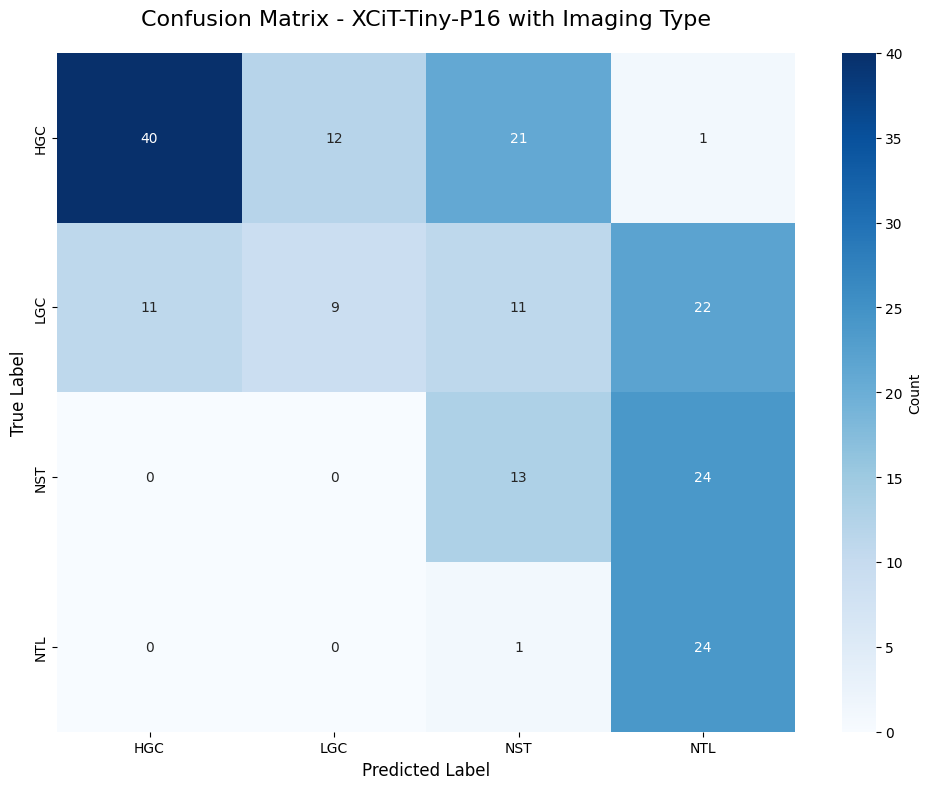

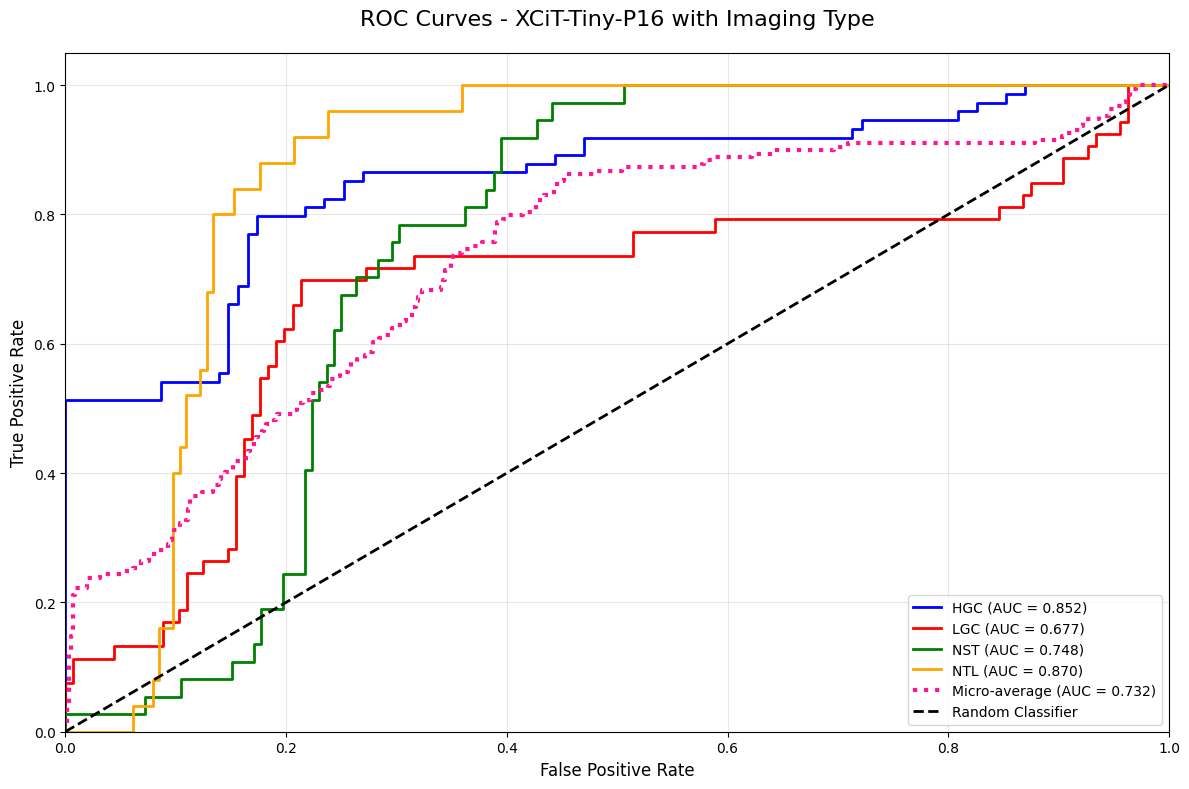


XCiT Tiny P16 with Imaging Type training and evaluation complete!


In [16]:
print("=" * 80)
print("Training XCiT Tiny P16 with Imaging Type")
print("=" * 80)

# Create model
xcit_tiny = create_xcit_model(model_size='tiny', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_tiny = ModelTrainer(xcit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_tiny = trainer_xcit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Tiny-P16_with_ImagingType")

# Plot training history
trainer_xcit_tiny.plot_training_history(save_path='xcit_tiny_p16_with_imaging_type_training_history.png')

# Evaluate model
results_xcit_tiny = trainer_xcit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_tiny['confusion_matrix'], class_names, 'XCiT-Tiny-P16 with Imaging Type',
                      save_path='xcit_tiny_p16_with_imaging_type_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_tiny = plot_roc_curves(results_xcit_tiny['labels'], results_xcit_tiny['probabilities'], class_names, 'XCiT-Tiny-P16 with Imaging Type',
                                     save_path='xcit_tiny_p16_with_imaging_type_roc_curves.png')

# Store results
results_xcit_tiny['model_name'] = 'XCiT-Tiny-P16_with_ImagingType'
results_xcit_tiny['roc_auc'] = roc_auc_xcit_tiny
all_results.append(results_xcit_tiny)

print("\nXCiT Tiny P16 with Imaging Type training and evaluation complete!")

## Train XCiT Small P16 with Imaging Type

Training XCiT Small P16 with Imaging Type


model.safetensors:   0%|          | 0.00/105M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.60it/s, Loss=1.3739, Acc=0.3594]


Train Loss: 1.3739 Acc: 0.3594 Macro-F1: 0.3164


Val : 100%|██████████| 10/10 [00:01<00:00,  6.49it/s, Loss=1.3777, Acc=0.2072]


Val Loss: 1.3777 Acc: 0.2072 Macro-F1: 0.1916
✓ New best model saved with validation macro-F1: 0.1916

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.3548, Acc=0.3199]


Train Loss: 1.3548 Acc: 0.3199 Macro-F1: 0.3076


Val : 100%|██████████| 10/10 [00:01<00:00,  7.83it/s, Loss=1.3252, Acc=0.3421]


Val Loss: 1.3252 Acc: 0.3421 Macro-F1: 0.1982
✓ New best model saved with validation macro-F1: 0.1982

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.2886, Acc=0.3914]


Train Loss: 1.2886 Acc: 0.3914 Macro-F1: 0.3429


Val : 100%|██████████| 10/10 [00:01<00:00,  7.16it/s, Loss=1.2863, Acc=0.3586]


Val Loss: 1.2863 Acc: 0.3586 Macro-F1: 0.2618
✓ New best model saved with validation macro-F1: 0.2618

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.3197, Acc=0.3824]


Train Loss: 1.3197 Acc: 0.3824 Macro-F1: 0.3213


Val : 100%|██████████| 10/10 [00:01<00:00,  7.59it/s, Loss=1.1575, Acc=0.4638]


Val Loss: 1.1575 Acc: 0.4638 Macro-F1: 0.3653
✓ New best model saved with validation macro-F1: 0.3653

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=1.2447, Acc=0.3947]


Train Loss: 1.2447 Acc: 0.3947 Macro-F1: 0.3606


Val : 100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Loss=1.2019, Acc=0.4539]


Val Loss: 1.2019 Acc: 0.4539 Macro-F1: 0.2900

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.1470, Acc=0.4885]


Train Loss: 1.1470 Acc: 0.4885 Macro-F1: 0.4141


Val : 100%|██████████| 10/10 [00:01<00:00,  7.21it/s, Loss=1.1753, Acc=0.3980]


Val Loss: 1.1753 Acc: 0.3980 Macro-F1: 0.3402

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.1721, Acc=0.4556]


Train Loss: 1.1721 Acc: 0.4556 Macro-F1: 0.4124


Val : 100%|██████████| 10/10 [00:01<00:00,  7.40it/s, Loss=1.0674, Acc=0.4737]


Val Loss: 1.0674 Acc: 0.4737 Macro-F1: 0.4189
✓ New best model saved with validation macro-F1: 0.4189

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=1.0261, Acc=0.5033]


Train Loss: 1.0261 Acc: 0.5033 Macro-F1: 0.4316


Val : 100%|██████████| 10/10 [00:01<00:00,  7.56it/s, Loss=0.9545, Acc=0.5132]


Val Loss: 0.9545 Acc: 0.5132 Macro-F1: 0.3939

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=1.0370, Acc=0.5312]


Train Loss: 1.0370 Acc: 0.5312 Macro-F1: 0.4619


Val : 100%|██████████| 10/10 [00:01<00:00,  7.55it/s, Loss=0.9107, Acc=0.5296]


Val Loss: 0.9107 Acc: 0.5296 Macro-F1: 0.4444
✓ New best model saved with validation macro-F1: 0.4444

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.9684, Acc=0.5633]


Train Loss: 0.9684 Acc: 0.5633 Macro-F1: 0.5241


Val : 100%|██████████| 10/10 [00:01<00:00,  7.67it/s, Loss=0.9115, Acc=0.5230]


Val Loss: 0.9115 Acc: 0.5230 Macro-F1: 0.3956

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.9501, Acc=0.5099]


Train Loss: 0.9501 Acc: 0.5099 Macro-F1: 0.4688


Val : 100%|██████████| 10/10 [00:01<00:00,  7.03it/s, Loss=0.9130, Acc=0.5066]


Val Loss: 0.9130 Acc: 0.5066 Macro-F1: 0.4262

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.9129, Acc=0.5238]


Train Loss: 0.9129 Acc: 0.5238 Macro-F1: 0.4920


Val : 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, Loss=0.8452, Acc=0.4836]


Val Loss: 0.8452 Acc: 0.4836 Macro-F1: 0.4479
✓ New best model saved with validation macro-F1: 0.4479

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.9035, Acc=0.5378]


Train Loss: 0.9035 Acc: 0.5378 Macro-F1: 0.5111


Val : 100%|██████████| 10/10 [00:01<00:00,  7.39it/s, Loss=1.0016, Acc=0.4803]


Val Loss: 1.0016 Acc: 0.4803 Macro-F1: 0.4181

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.8840, Acc=0.5658]


Train Loss: 0.8840 Acc: 0.5658 Macro-F1: 0.5374


Val : 100%|██████████| 10/10 [00:01<00:00,  7.58it/s, Loss=0.8049, Acc=0.5724]


Val Loss: 0.8049 Acc: 0.5724 Macro-F1: 0.5315
✓ New best model saved with validation macro-F1: 0.5315

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.8452, Acc=0.5625]


Train Loss: 0.8452 Acc: 0.5625 Macro-F1: 0.5500


Val : 100%|██████████| 10/10 [00:01<00:00,  6.93it/s, Loss=0.7832, Acc=0.5757]


Val Loss: 0.7832 Acc: 0.5757 Macro-F1: 0.5436
✓ New best model saved with validation macro-F1: 0.5436

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.8395, Acc=0.5781]


Train Loss: 0.8395 Acc: 0.5781 Macro-F1: 0.5535


Val : 100%|██████████| 10/10 [00:01<00:00,  7.41it/s, Loss=0.7723, Acc=0.6217]


Val Loss: 0.7723 Acc: 0.6217 Macro-F1: 0.5884
✓ New best model saved with validation macro-F1: 0.5884

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.8178, Acc=0.6069]


Train Loss: 0.8178 Acc: 0.6069 Macro-F1: 0.5783


Val : 100%|██████████| 10/10 [00:01<00:00,  7.71it/s, Loss=0.8161, Acc=0.5724]


Val Loss: 0.8161 Acc: 0.5724 Macro-F1: 0.5345

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.8147, Acc=0.5979]


Train Loss: 0.8147 Acc: 0.5979 Macro-F1: 0.5813


Val : 100%|██████████| 10/10 [00:01<00:00,  7.72it/s, Loss=0.7697, Acc=0.6645]


Val Loss: 0.7697 Acc: 0.6645 Macro-F1: 0.6367
✓ New best model saved with validation macro-F1: 0.6367

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.8119, Acc=0.5650]


Train Loss: 0.8119 Acc: 0.5650 Macro-F1: 0.5463


Val : 100%|██████████| 10/10 [00:01<00:00,  7.70it/s, Loss=0.7724, Acc=0.6382]


Val Loss: 0.7724 Acc: 0.6382 Macro-F1: 0.6133

Epoch 20/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.8006, Acc=0.5863]


Train Loss: 0.8006 Acc: 0.5863 Macro-F1: 0.5715


Val : 100%|██████████| 10/10 [00:01<00:00,  7.74it/s, Loss=0.7549, Acc=0.6678]


Val Loss: 0.7549 Acc: 0.6678 Macro-F1: 0.6438
✓ New best model saved with validation macro-F1: 0.6438

Epoch 21/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.7745, Acc=0.5979]


Train Loss: 0.7745 Acc: 0.5979 Macro-F1: 0.5780


Val : 100%|██████████| 10/10 [00:01<00:00,  7.83it/s, Loss=0.7459, Acc=0.6809]


Val Loss: 0.7459 Acc: 0.6809 Macro-F1: 0.6543
✓ New best model saved with validation macro-F1: 0.6543

Epoch 22/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.8017, Acc=0.5905]


Train Loss: 0.8017 Acc: 0.5905 Macro-F1: 0.5739


Val : 100%|██████████| 10/10 [00:01<00:00,  7.82it/s, Loss=0.7488, Acc=0.6743]


Val Loss: 0.7488 Acc: 0.6743 Macro-F1: 0.6460

Epoch 23/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.63it/s, Loss=0.7755, Acc=0.6028]


Train Loss: 0.7755 Acc: 0.6028 Macro-F1: 0.5848


Val : 100%|██████████| 10/10 [00:01<00:00,  7.77it/s, Loss=0.7492, Acc=0.6842]


Val Loss: 0.7492 Acc: 0.6842 Macro-F1: 0.6567
✓ New best model saved with validation macro-F1: 0.6567

Epoch 24/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.7664, Acc=0.6044]


Train Loss: 0.7664 Acc: 0.6044 Macro-F1: 0.5884


Val : 100%|██████████| 10/10 [00:01<00:00,  7.57it/s, Loss=0.7532, Acc=0.6678]


Val Loss: 0.7532 Acc: 0.6678 Macro-F1: 0.6385

Epoch 25/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.64it/s, Loss=0.7817, Acc=0.5913]


Train Loss: 0.7817 Acc: 0.5913 Macro-F1: 0.5729


Val : 100%|██████████| 10/10 [00:01<00:00,  7.77it/s, Loss=0.7513, Acc=0.6743]


Val Loss: 0.7513 Acc: 0.6743 Macro-F1: 0.6444

Training complete in 10m 19s
Best validation macro-F1: 0.6567


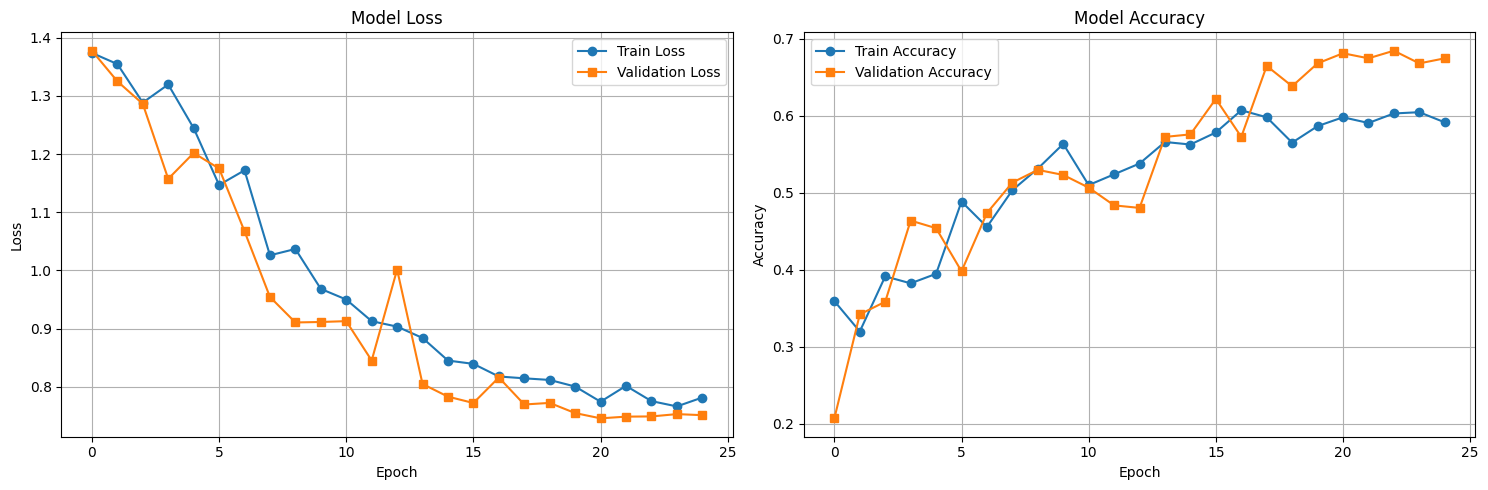

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.82it/s]


Test Accuracy: 25.93%
Test Loss: 1.4754

Classification Report:
              precision    recall  f1-score   support

         HGC       0.35      0.11      0.16        74
         LGC       0.00      0.00      0.00        53
         NST       0.52      0.65      0.58        37
         NTL       0.24      0.68      0.36        25

    accuracy                           0.26       189
   macro avg       0.28      0.36      0.28       189
weighted avg       0.27      0.26      0.23       189


Confusion Matrix:
[[ 8 50  6 10]
 [15  0  8 30]
 [ 0  0 24 13]
 [ 0  0  8 17]]

ROC-AUC Scores:
Macro-average AUC: 0.7500
Micro-average AUC: 0.7067
HGC AUC: 0.8699
LGC AUC: 0.4815
NST AUC: 0.8675
NTL AUC: 0.7810


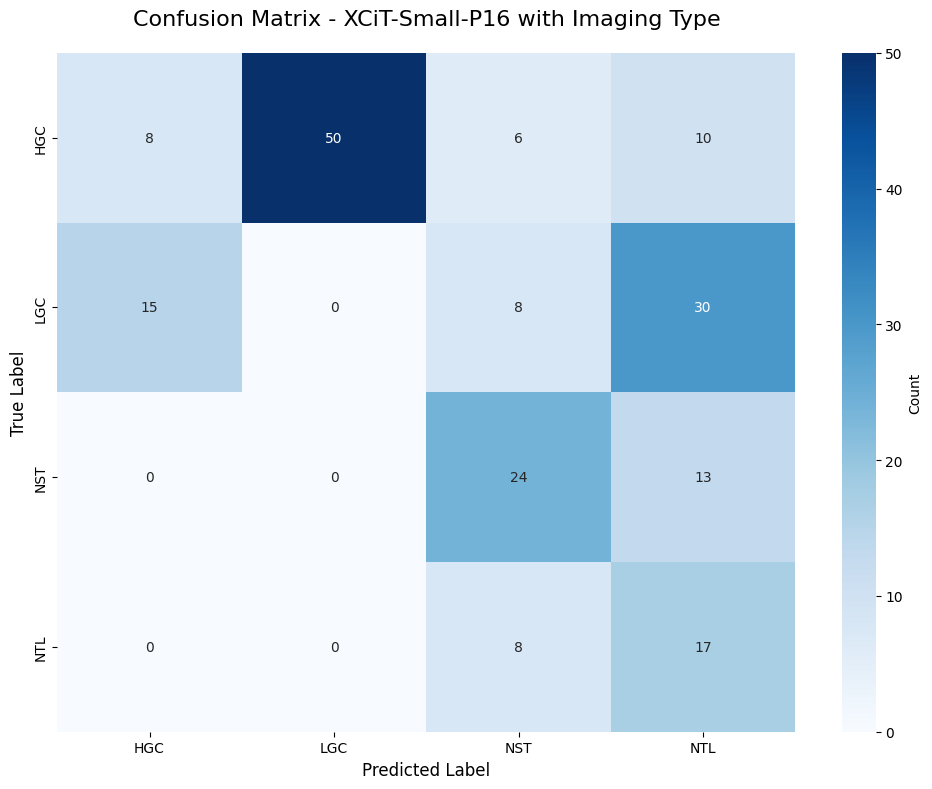

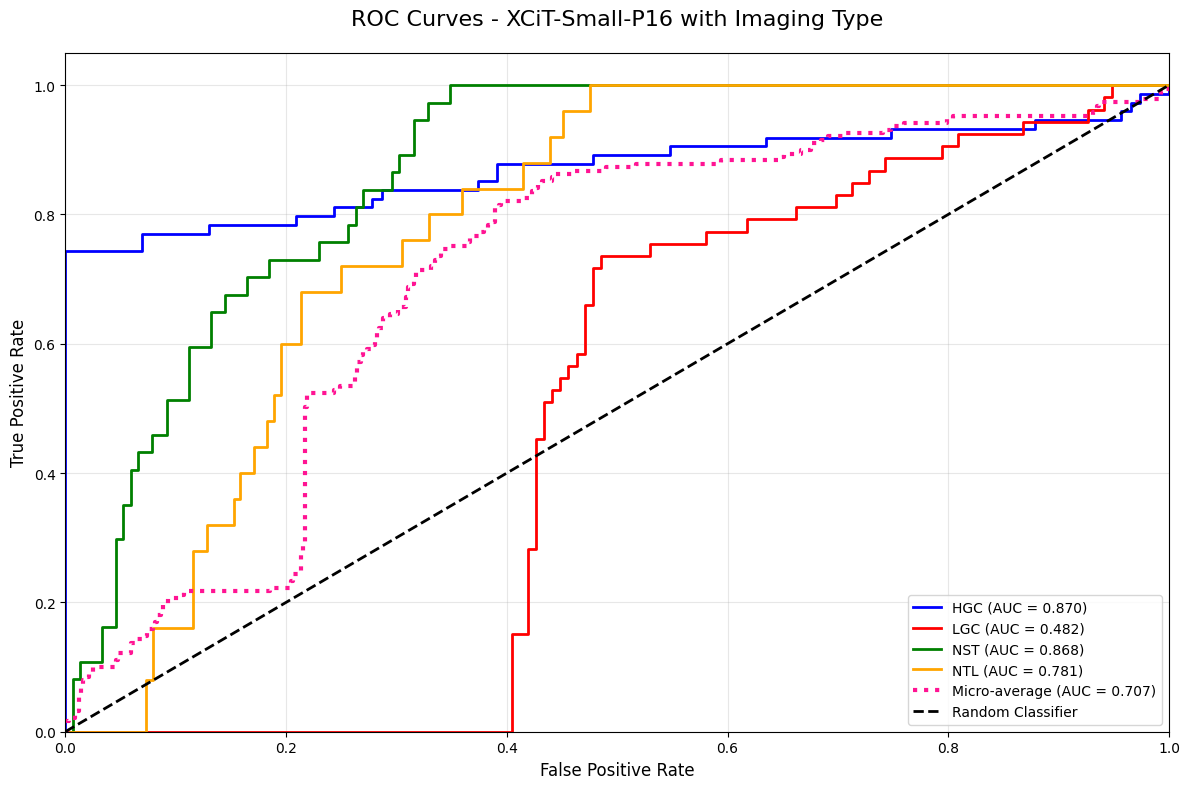


XCiT Small P16 with Imaging Type training and evaluation complete!


In [17]:
print("=" * 80)
print("Training XCiT Small P16 with Imaging Type")
print("=" * 80)

# Create model
xcit_small = create_xcit_model(model_size='small', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_small = ModelTrainer(xcit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_small = trainer_xcit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Small-P16_with_ImagingType")

# Plot training history
trainer_xcit_small.plot_training_history(save_path='xcit_small_p16_with_imaging_type_training_history.png')

# Evaluate model
results_xcit_small = trainer_xcit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_small['confusion_matrix'], class_names, 'XCiT-Small-P16 with Imaging Type',
                      save_path='xcit_small_p16_with_imaging_type_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_small = plot_roc_curves(results_xcit_small['labels'], results_xcit_small['probabilities'], class_names, 'XCiT-Small-P16 with Imaging Type',
                                      save_path='xcit_small_p16_with_imaging_type_roc_curves.png')

# Store results
results_xcit_small['model_name'] = 'XCiT-Small-P16_with_ImagingType'
results_xcit_small['roc_auc'] = roc_auc_xcit_small
all_results.append(results_xcit_small)

print("\nXCiT Small P16 with Imaging Type training and evaluation complete!")

## Train XCiT Medium P16 with Imaging Type

Training XCiT Medium P16 with Imaging Type


model.safetensors:   0%|          | 0.00/338M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.65s/it, Loss=1.4113, Acc=0.2738]


Train Loss: 1.4113 Acc: 0.2738 Macro-F1: 0.2394


Val : 100%|██████████| 10/10 [00:02<00:00,  3.43it/s, Loss=1.3936, Acc=0.2763]


Val Loss: 1.3936 Acc: 0.2763 Macro-F1: 0.1082
✓ New best model saved with validation macro-F1: 0.1082

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.4044, Acc=0.2607]


Train Loss: 1.4044 Acc: 0.2607 Macro-F1: 0.2223


Val : 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, Loss=1.3942, Acc=0.3289]


Val Loss: 1.3942 Acc: 0.3289 Macro-F1: 0.1849
✓ New best model saved with validation macro-F1: 0.1849

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.3873, Acc=0.2985]


Train Loss: 1.3873 Acc: 0.2985 Macro-F1: 0.2456


Val : 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, Loss=1.3665, Acc=0.2763]


Val Loss: 1.3665 Acc: 0.2763 Macro-F1: 0.1082

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.3928, Acc=0.2336]


Train Loss: 1.3928 Acc: 0.2336 Macro-F1: 0.2158


Val : 100%|██████████| 10/10 [00:02<00:00,  3.74it/s, Loss=1.3633, Acc=0.3684]


Val Loss: 1.3633 Acc: 0.3684 Macro-F1: 0.1346

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.3929, Acc=0.3215]


Train Loss: 1.3929 Acc: 0.3215 Macro-F1: 0.2326


Val : 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, Loss=1.3789, Acc=0.2763]


Val Loss: 1.3789 Acc: 0.2763 Macro-F1: 0.1082

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.3941, Acc=0.2714]


Train Loss: 1.3941 Acc: 0.2714 Macro-F1: 0.2203


Val : 100%|██████████| 10/10 [00:02<00:00,  3.75it/s, Loss=1.3825, Acc=0.3684]


Val Loss: 1.3825 Acc: 0.3684 Macro-F1: 0.1346

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [01:02<00:00,  1.64s/it, Loss=1.3887, Acc=0.2903]


Train Loss: 1.3887 Acc: 0.2903 Macro-F1: 0.2493


Val : 100%|██████████| 10/10 [00:02<00:00,  3.77it/s, Loss=1.3766, Acc=0.3684]


Val Loss: 1.3766 Acc: 0.3684 Macro-F1: 0.1346
Early stopping triggered after 7 epochs
Training complete in 7m 36s
Best validation macro-F1: 0.1849


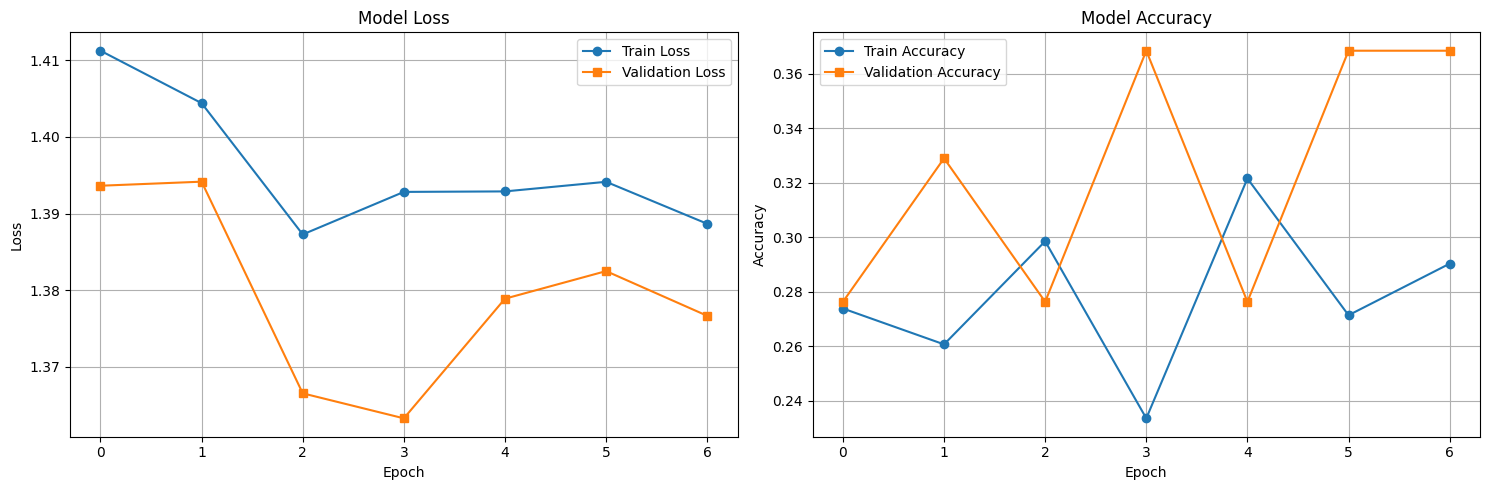

Evaluating on test set...


100%|██████████| 6/6 [00:02<00:00,  2.84it/s]
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/us

Test Accuracy: 13.76%
Test Loss: 1.4002

Classification Report:
              precision    recall  f1-score   support

         HGC       0.00      0.00      0.00        74
         LGC       0.17      0.49      0.26        53
         NST       0.00      0.00      0.00        37
         NTL       0.00      0.00      0.00        25

    accuracy                           0.14       189
   macro avg       0.04      0.12      0.06       189
weighted avg       0.05      0.14      0.07       189


Confusion Matrix:
[[ 0 62  0 12]
 [ 0 26  0 27]
 [ 0 37  0  0]
 [ 0 25  0  0]]

ROC-AUC Scores:
Macro-average AUC: 0.6752
Micro-average AUC: 0.4570
HGC AUC: 0.8228
LGC AUC: 0.3581
NST AUC: 0.9539
NTL AUC: 0.5662


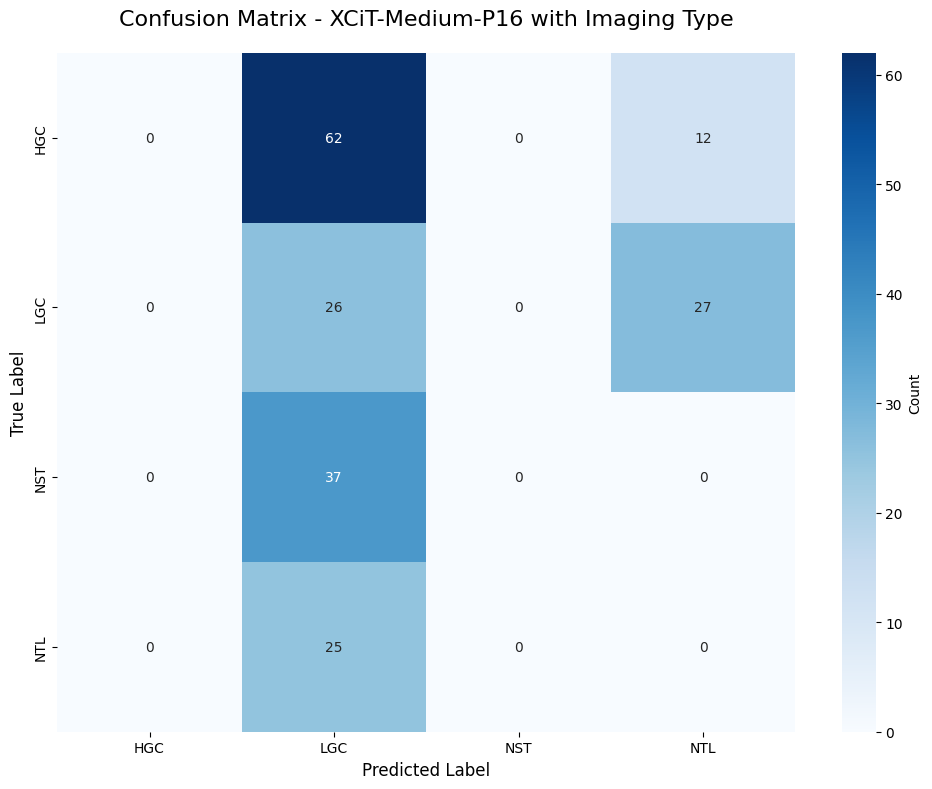

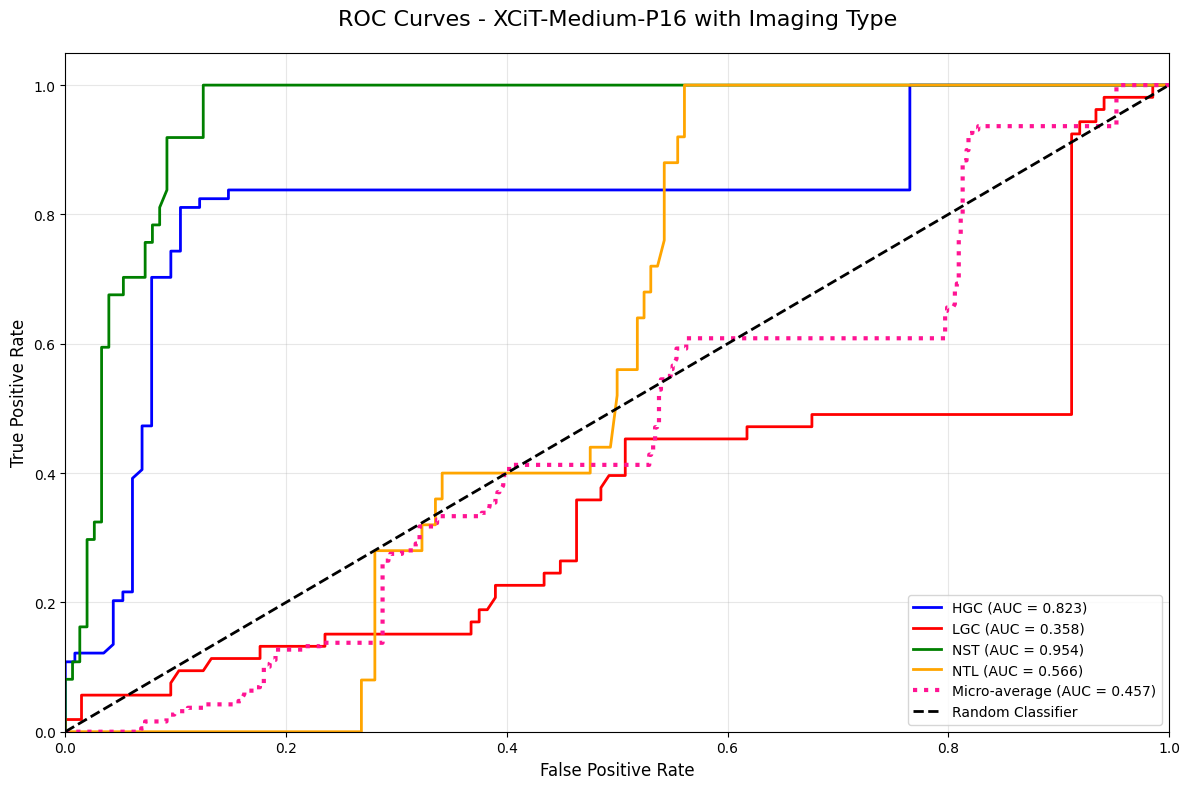


XCiT Medium P16 with Imaging Type training and evaluation complete!


In [18]:
print("=" * 80)
print("Training XCiT Medium P16 with Imaging Type")
print("=" * 80)

# Create model
xcit_medium = create_xcit_model(model_size='medium', num_classes=4, pretrained=True)

# Create trainer
trainer_xcit_medium = ModelTrainer(xcit_medium, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_xcit_medium = trainer_xcit_medium.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="XCiT-Medium-P16_with_ImagingType")

# Plot training history
trainer_xcit_medium.plot_training_history(save_path='xcit_medium_p16_with_imaging_type_training_history.png')

# Evaluate model
results_xcit_medium = trainer_xcit_medium.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_xcit_medium['confusion_matrix'], class_names, 'XCiT-Medium-P16 with Imaging Type',
                      save_path='xcit_medium_p16_with_imaging_type_confusion_matrix.png')

# Plot ROC curves
roc_auc_xcit_medium = plot_roc_curves(results_xcit_medium['labels'], results_xcit_medium['probabilities'], class_names, 'XCiT-Medium-P16 with Imaging Type',
                                       save_path='xcit_medium_p16_with_imaging_type_roc_curves.png')

# Store results
results_xcit_medium['model_name'] = 'XCiT-Medium-P16_with_ImagingType'
results_xcit_medium['roc_auc'] = roc_auc_xcit_medium
all_results.append(results_xcit_medium)

print("\nXCiT Medium P16 with Imaging Type training and evaluation complete!")

# Save All Metrics to CSV

In [19]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'XCiT_with_ImagingType_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: XCiT_with_ImagingType_metrics.csv

Metrics Summary:
                              Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0    XCiT-Tiny-P16_with_ImagingType         45.502646      2.268537             0.458381          0.505426      0.424124                0.527305             0.455026         0.446255       0.784314    0.540541  0.640000         74.0       0.428571    0.169811  0.243243         53.0       0.282609    0.351351  0.313253         37.0       0.338028        0.96  0.500000         25.0   0.786398   0.731661  0.